## Machine learning on Social Netowrk Graphs

In [10]:
import os
import math
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

default_edge_color = 'gray'
default_node_color = '#407cc9'
enhanced_node_color = '#f5b042'
enhanced_edge_color = '#cc2f04'

In this chapter we will focus on using the techniques outlined in previous chapters to analyze the most-common example of nowadays graphs: Social Networks. In particular we will apply the techniques outlined in previous chapters to investigate the topological properties of the networks, such as 
1. identifying relevant communities as well as 
2. identifying particularly important nodes in the network. 

We will then use node embeddings to leverage on the power of topological information for different tasks, such as link prediction (as a potential recommendation engine for new friends) 

#### Dowload the dataset

First, we need to download the dataset. We will be using the [SNAP Facebook social graph](http://snap.stanford.edu). The dataset was created by collection Facebook user information from survey participants.  More in detail, 10 ego-networks were created from ten users. Each user was asked to identify all the circles (list of friends) to which their friends belong. Then, all the "ego-network" were combined in a single graph.

In [11]:
!wget http://snap.stanford.edu/data/facebook_combined.txt.gz
!wget http://snap.stanford.edu/data/facebook.tar.gz
!gzip -d facebook_combined.txt.gz
!tar -xf facebook.tar.gz

"wget" no se reconoce como un comando interno o externo,
programa o archivo por lotes ejecutable.
"wget" no se reconoce como un comando interno o externo,
programa o archivo por lotes ejecutable.
"gzip" no se reconoce como un comando interno o externo,
programa o archivo por lotes ejecutable.
tar: Error opening archive: Failed to open 'facebook.tar.gz'


### Overview of the Dataset

The code above downloads two main files:
*   a text file containing the edge list of the graph. The graph is actually created
*   an archive containing a folder ("facebook") with all the information related to each ego-network



In [12]:
# check the downloaded content
!ls

"ls" no se reconoce como un comando interno o externo,
programa o archivo por lotes ejecutable.


In [13]:
# take a look at the first lines of the edge list
!head facebook_combined.txt

"head" no se reconoce como un comando interno o externo,
programa o archivo por lotes ejecutable.


We can now proceed loading the combined network using networkx. We will also load the nodeId of the 10 "ego-user"

In [14]:
G = nx.read_edgelist("facebook_combined.txt", create_using=nx.Graph(), nodetype=int)

In [15]:
print(G)

Graph with 4039 nodes and 88234 edges


In [16]:
# Each file in the "facebook" directory is named as nodeId.format
# where nodeId is the id of an ego-user and format is the format of the file
ego_nodes = set([int(name.split('.')[0]) for name in os.listdir("facebook/")])

Let's visualize the network for a deeper understanding

In [17]:
#Create network layout for visualizations
spring_pos = nx.spring_layout(G)

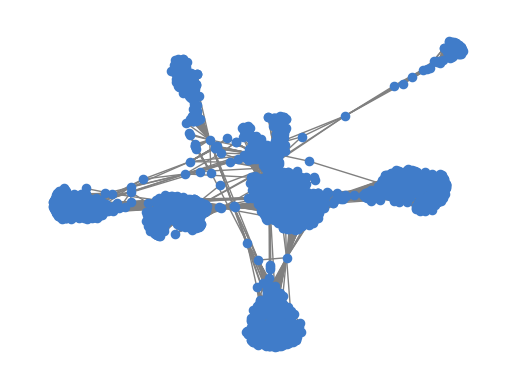

In [18]:
plt.axis("off")
nx.draw_networkx(G, pos=spring_pos, node_color=default_node_color, edge_color=default_edge_color, with_labels=False, node_size=35)

### Network Analysis

In [19]:
def draw_metric(G, dct, spring_pos):
  """ draw the graph G using the layout spring_pos.
      The top 10 nodes w.r.t. values in the dictionary dct
      are enhanced in the visualization """
  top = 10
  max_nodes =  sorted(dct.items(), key = lambda v: -v[1])[:top]
  
  max_keys = [key for key,_ in max_nodes]
  max_vals = [val*300 for _, val in max_nodes]

  plt.axis("off")
  
  nx.draw_networkx(G, 
                   pos=spring_pos, 
                   cmap='Blues', 
                   edge_color=default_edge_color,
                   node_color=default_node_color, 
                   node_size=3,
                   alpha=0.4, 
                   with_labels=False)
  
  nx.draw_networkx_nodes(G, 
                         pos=spring_pos, 
                         nodelist=max_keys, 
                         node_color=enhanced_edge_color,
                         node_size=max_vals)

In [20]:
# betweenness centrality
bC = nx.betweenness_centrality(G)
np.mean(list(bC.values()))

0.0006669573568730229

d:\Users\Juan Jose Viafara\miniconda3\envs\venv3\lib\site-packages\networkx\drawing\nx_pylab.py:433: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


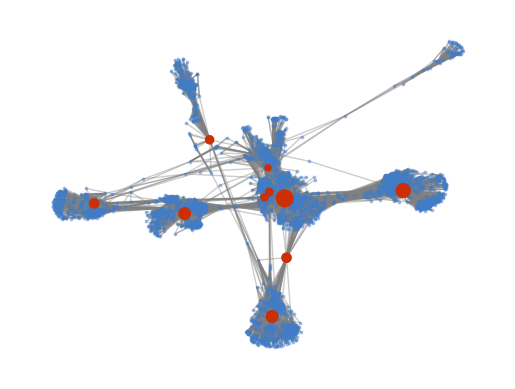

In [21]:
draw_metric(G,bC,spring_pos)

In [22]:
# global efficiency
gE = nx.global_efficiency(G)
print(gE)

0.30657814798734856


In [23]:
# average clustering
aC = nx.average_clustering(G)
print(aC)

0.6055467186200876


In [24]:
# degree centrality
deg_C = nx.degree_centrality(G)
np.mean(list(deg_C.values()))

0.010819963503439287

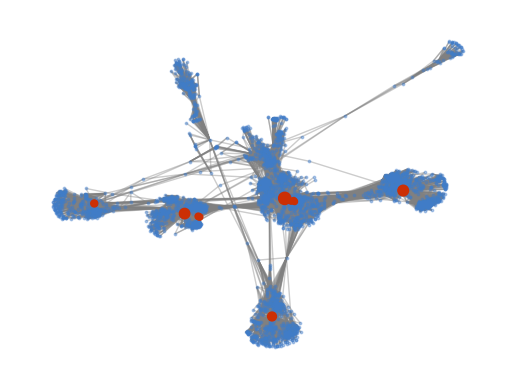

In [25]:
draw_metric(G,deg_C,spring_pos)

In [26]:
# closeness centrality
clos_C = nx.closeness_centrality(G)
np.mean(list(clos_C.values()))

0.2761677635668376

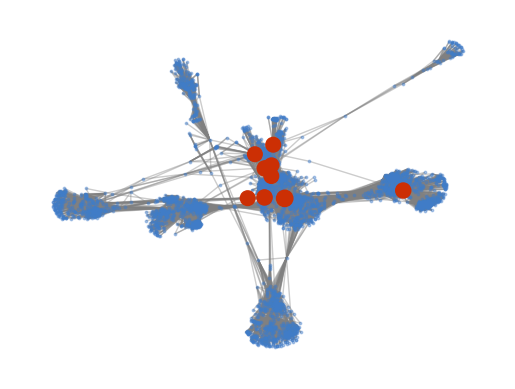

In [27]:
draw_metric(G,clos_C,spring_pos)

In [28]:
# assortativity
assortativity = nx.degree_pearson_correlation_coefficient(G)
assortativity

0.06357722918564661

In [29]:
t = nx.transitivity(G)
t

0.5191742775433075

In [30]:
#import networkx.algorithms.community as nx_comm
#nx_comm.modularity(G, nx_comm.label_propagation_communities(G))

#### Community detection
In the following cells we will automatically detect communities using infromation from the network topology

In [47]:
!conda install pip
!conda install gensim
!pip install python-louvain

0 is in community number 0
107 is in community number 1
3980 is in community number 12
3437 is in community number 8
686 is in community number 13
1684 is in community number 4
1912 is in community number 14
698 is in community number 13
348 is in community number 3
414 is in community number 3


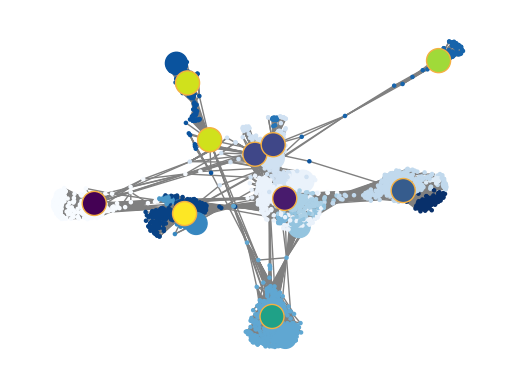

In [32]:
import community

parts = community.best_partition(G)
values = [parts.get(node) for node in G.nodes()]

for node in ego_nodes:
  print(node, "is in community number", parts.get(node))
  
n_sizes = [5]*len(G.nodes())
for node in ego_nodes:
  n_sizes[node] = 250

plt.axis("off")
nx.draw_networkx(G, pos=spring_pos, cmap=plt.get_cmap("Blues"), edge_color=default_edge_color, node_color=values, node_size=n_sizes, with_labels=False)

# enhance color and size of the ego-nodes
nodes = nx.draw_networkx_nodes(G,spring_pos,ego_nodes,node_color=[parts.get(node) for node in ego_nodes])
nodes.set_edgecolor(enhanced_node_color)

### Ego-net analysis

Since the combined network we are analyzing is actually composed by 10 sub-networks (ego-networks), it's interesting to inspect all those subnetwork. In the following cells we will analyze the subnetwork of the ego-user "0".

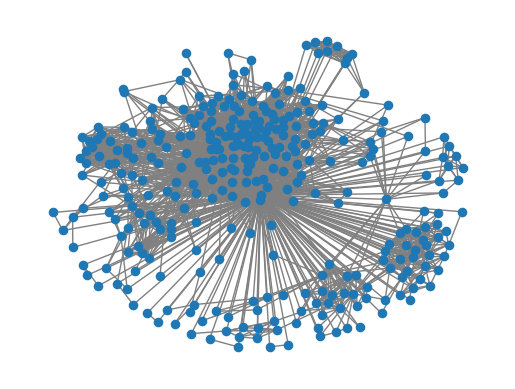

In [33]:
G0 = nx.read_edgelist("facebook/0.edges", create_using=nx.Graph(), nodetype=int)
for node in G0.copy():
  G0.add_edge(0,node)

plt.axis("off")
pos_G0 = nx.spring_layout(G0)
nx.draw_networkx(G0, pos=pos_G0, with_labels=False, node_size=35, edge_color=default_edge_color)

Nodes belonging to each subnetwork are stored in the "facebook" folder under the name nodeId.circles

In [34]:
import pandas as pd
circles = {}

with open("facebook/0.circles") as f_in:
  line = f_in.readline().rstrip().split("\t")
  while line and not '' in line:
    circles[line[0]] = [int(v) for v in line[1:]]
    line = f_in.readline().rstrip().split("\t")

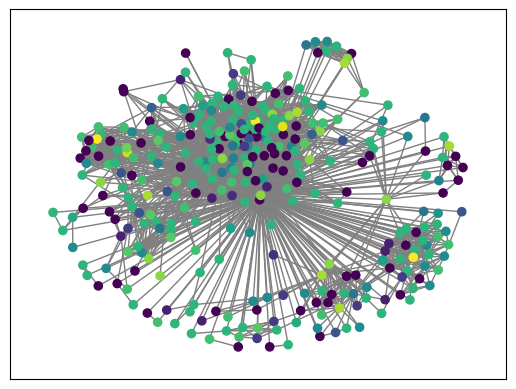

In [35]:
node_colors = [0] * G0.number_of_nodes()
count = 0
for key in circles:
  circle = circles[key]
  for node in circle:
    if node < G0.number_of_nodes():
      node_colors[node] = count
  count += 1

nx.draw_networkx(G0, pos=pos_G0, with_labels=False, node_size=35, node_color=node_colors, edge_color=default_edge_color)

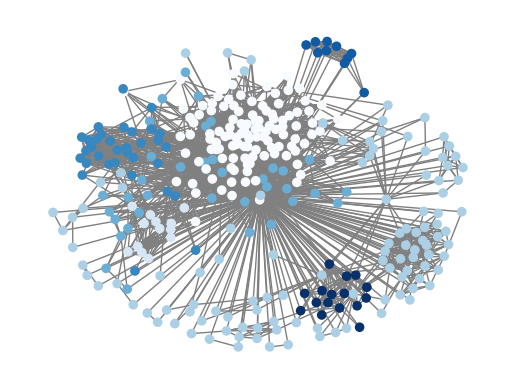

In [36]:
parts = community.best_partition(G0)
values = [parts.get(node) for node in G0.nodes()]

plt.axis("off")
nx.draw_networkx(G0, pos=pos_G0, cmap=plt.get_cmap("Blues"), edge_color=default_edge_color, node_color=values, node_size=35, with_labels=False)

In [37]:
# community found does not reflect the circles
set(parts.values())
len(circles)

24

In [38]:
# a node can be present in more than one list??
for i in circles:
  for j in circles:
    if i != j:
      for n1 in circles[i]:
        for n2 in circles[j]:
          if n1 == n2:
            print(n1, 'present in ',i,'found in', j)

54 present in  circle0 found in circle11
298 present in  circle0 found in circle11
97 present in  circle0 found in circle11
183 present in  circle0 found in circle15
173 present in  circle1 found in circle16
125 present in  circle4 found in circle15
55 present in  circle4 found in circle15
122 present in  circle4 found in circle15
280 present in  circle4 found in circle15
236 present in  circle4 found in circle15
69 present in  circle4 found in circle15
258 present in  circle4 found in circle16
23 present in  circle5 found in circle15
52 present in  circle6 found in circle17
93 present in  circle6 found in circle19
17 present in  circle6 found in circle19
137 present in  circle6 found in circle19
343 present in  circle6 found in circle19
326 present in  circle6 found in circle19
214 present in  circle6 found in circle19
115 present in  circle6 found in circle19
312 present in  circle6 found in circle19
41 present in  circle6 found in circle19
20 present in  circle6 found in circle19
28

In [39]:
#@title  
nx.average_shortest_path_length(G0)
nx.global_efficiency(G0)
nx.average_clustering(G0)

np.mean(list(nx.betweenness_centrality(G0).values()))
np.mean(list(nx.closeness_centrality(G0).values()))
np.mean(list(nx.degree_centrality(G0).values()))
nx.degree_pearson_correlation_coefficient(G)
nx.transitivity(G)

import networkx.algorithms.community as nx_comm
nx_comm.modularity(G, nx_comm.label_propagation_communities(G))

0.7368407345348218

### Embeddings for Supervised and Unsupervised Tasks 

We will now proceed with the actual machine learning task. In particular, we will perform an edge prediction task for the Facebook social graph.

#### parse node features

As first, let's load all the features describing each node. This is not a straightforward process and requires a bit of codes, since each subnetwork contains it's own set of features, whose names and values are stored in different files. 

In [40]:
# Adapted from https://github.com/jcatw/snap-facebook

feat_file_name = "feature_map.txt"
feature_index = {}  #numeric index to name
inverted_feature_index = {} #name to numeric index
network = nx.Graph()

def parse_featname_line(line):
  """ used to parse each line of the files containing feature names """
  line = line[(line.find(' '))+1:]  # chop first field
  split = line.split(';')
  name = ';'.join(split[:-1]) # feature name
  index = int(split[-1].split(" ")[-1]) #feature index
  return index, name

def load_features():
  """ 
  parse each ego-network and creates two dictionaries:
      - feature_index: maps numeric indices to names
      - inverted_feature_index: maps names to numeric indices
  """
  import glob
  feat_file_name = 'tmp.txt'
  # may need to build the index first
  if not os.path.exists(feat_file_name):
      feat_index = {}
      # build the index from data/*.featnames files
      featname_files = glob.iglob("facebook/*.featnames")
      for featname_file_name in featname_files:
          featname_file = open(featname_file_name, 'r')
          for line in featname_file:
              # example line:
              # 0 birthday;anonymized feature 376
              index, name = parse_featname_line(line)
              feat_index[index] = name
          featname_file.close()
      keys = feat_index.keys()
      keys = sorted(keys)
      out = open(feat_file_name,'w')
      for key in keys:
          out.write("%d %s\n" % (key, feat_index[key]))
      out.close()

  index_file = open(feat_file_name,'r')
  for line in index_file:
      split = line.strip().split(' ')
      key = int(split[0])
      val = split[1]
      feature_index[key] = val
  index_file.close()

  for key in feature_index.keys():
      val = feature_index[key]
      inverted_feature_index[val] = key

def parse_nodes(network, ego_nodes):
  """
  for each nodes in the network assign the corresponding features 
  previously loaded using the load_features function
  """
  # parse each node
  for node_id in ego_nodes:
      featname_file = open(f'facebook/{node_id}.featnames','r')
      feat_file     = open(f'facebook/{node_id}.feat','r')
      egofeat_file  = open(f'facebook/{node_id}.egofeat','r')
      edge_file     = open(f'facebook/{node_id}.edges','r')

      ego_features = [int(x) for x in egofeat_file.readline().split(' ')]

      # Add ego node features
      network.nodes[node_id]['features'] = np.zeros(len(feature_index))
      
      # parse ego node
      i = 0
      for line in featname_file:
          key, val = parse_featname_line(line)
          # Update feature value if necessary
          if ego_features[i] + 1 > network.nodes[node_id]['features'][key]:
              network.nodes[node_id]['features'][key] = ego_features[i] + 1
          i += 1

      # parse neighboring nodes
      for line in feat_file:
          featname_file.seek(0)
          split = [int(x) for x in line.split(' ')]
          node_id = split[0]
          features = split[1:]

          # Add node features
          network.nodes[node_id]['features'] = np.zeros(len(feature_index))

          i = 0
          for line in featname_file:
              key, val = parse_featname_line(line)
              # Update feature value if necessary
              if features[i] + 1 > network.nodes[node_id]['features'][key]:
                  network.nodes[node_id]['features'][key] = features[i] + 1
              i += 1
          
      featname_file.close()
      feat_file.close()
      egofeat_file.close()
      edge_file.close()

In [41]:
# parse edge features and add them to the networkx nodes
load_features()
parse_nodes(G, ego_nodes)

In [42]:
# check features has been correctly assigned
G.nodes[0]

{'features': array([1., 1., 1., ..., 0., 0., 0.])}

### Link prediction
It's now time for machine learning.
As first, we will be using stellargraph utility function to define a train and test set.
More in detail, TODO

In [43]:
!pip install stellargraph
!pip install node2vec==0.3.3
!pip install git+https://github.com/palash1992/GEM.git
!pip install chardet

  Cloning https://github.com/palash1992/GEM.git to c:\users\juan jose viafara\appdata\local\temp\pip-req-build-h2usybe4
  Resolved https://github.com/palash1992/GEM.git to commit ae8e92d34213f5785757b4a0943bd7d8d337adb3
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'


  Running command git clone --filter=blob:none --quiet https://github.com/palash1992/GEM.git 'C:\Users\Juan Jose Viafara\AppData\Local\Temp\pip-req-build-h2usybe4'


In [66]:
from sklearn.model_selection import train_test_split
from stellargraph.data import EdgeSplitter
from stellargraph import StellarGraph

edgeSplitter = EdgeSplitter(G) 
graph_test, samples_test, labels_test = edgeSplitter.train_test_split(p=0.1, method="global", seed=24)

edgeSplitter = EdgeSplitter(graph_test, G) 
graph_train, samples_train, labels_train = edgeSplitter.train_test_split(p=0.1, method="global", seed=24)

TypeError: got an unexpected keyword argument 'p'

We will be comparing three different methods for predicting missing edges:
- Method1: node2vec will be used to learn a node embedding. Such embeddings will be used to train a Random Forest classifier in a supervised manner
- Method2: graphSAGE (with and without features) will be used for link prediction
- Method3: hand-crafted features will be extracted and used to train a Random Forest classifier

##### node2vec


In [48]:
from node2vec import Node2Vec
from node2vec.edges import HadamardEmbedder 
from stellargraph.data import EdgeSplitter 

node2vec = Node2Vec(graph_train) 
model = node2vec.fit() 
edges_embs = HadamardEmbedder(keyed_vectors=model.wv) 
train_embeddings = [edges_embs[str(x[0]),str(x[1])] for x in samples_train]

edges_embs = HadamardEmbedder(keyed_vectors=model.wv) 
test_embeddings = [edges_embs[str(x[0]),str(x[1])] for x in samples_test]

Generating walks (CPU: 1): 100%|██████████| 10/10 [01:49<00:00, 10.96s/it]


TypeError: __init__() got an unexpected keyword argument 'size'

In [ ]:
from node2vec import Node2Vec
from node2vec.edges import HadamardEmbedder 
from stellargraph.data import EdgeSplitter 


node2vec = Node2Vec(graph_train) 



Computing transition probabilities:   2%|▏         | 67/4039 [00:00<00:05, 668.98it/s]

Generating walks (CPU: 1): 100%|██████████| 10/10 [01:38<00:00,  9.82s/it]


In [ ]:
"""
model = node2vec.fit() 

edges_embs = HadamardEmbedder(keyed_vectors=model.wv) 
train_embeddings = [edges_embs[str(x[0]), str(x[1])] for x in samples_train]

edges_embs = HadamardEmbedder(keyed_vectors=model.wv) 
test_embeddings = [edges_embs[str(x[0]), str(x[1])] for x in samples_test]"""

'\nmodel = node2vec.fit() \n\nedges_embs = HadamardEmbedder(keyed_vectors=model.wv) \ntrain_embeddings = [edges_embs[str(x[0]), str(x[1])] for x in samples_train]\n\nedges_embs = HadamardEmbedder(keyed_vectors=model.wv) \ntest_embeddings = [edges_embs[str(x[0]), str(x[1])] for x in samples_test]'

In [49]:
from sklearn.ensemble import RandomForestClassifier 
from sklearn import metrics 

rf = RandomForestClassifier(n_estimators=10) 
rf.fit(train_embeddings, labels_train); 
 
y_pred = rf.predict(test_embeddings) 
print('Precision:', metrics.precision_score(labels_test, y_pred)) 
print('Recall:', metrics.recall_score(labels_test, y_pred)) 
print('F1-Score:', metrics.f1_score(labels_test, y_pred)) 

NameError: name 'train_embeddings' is not defined

##### graphSAGE

In [50]:
# graphSAGE no feats

In [51]:
eye = np.eye(graph_train.number_of_nodes())
fake_features = {n:eye[n] for n in G.nodes()}
nx.set_node_attributes(graph_train, fake_features, "fake")

eye = np.eye(graph_test.number_of_nodes())
fake_features = {n:eye[n] for n in G.nodes()}
nx.set_node_attributes(graph_test, fake_features, "fake")

In [52]:
graph_train.nodes[0]

{'features': array([1., 1., 1., ..., 0., 0., 0.]),
 'fake': array([1., 0., 0., ..., 0., 0., 0.])}

In [53]:
from stellargraph.mapper import GraphSAGELinkGenerator

batch_size = 64
num_samples = [4, 4]

sg_graph_train = StellarGraph.from_networkx(graph_train, node_features="fake")
sg_graph_test = StellarGraph.from_networkx(graph_test, node_features="fake")

train_gen = GraphSAGELinkGenerator(sg_graph_train, batch_size, num_samples)
train_flow = train_gen.flow(samples_train, labels_train, shuffle=True, seed=24)

test_gen = GraphSAGELinkGenerator(sg_graph_test, batch_size, num_samples)
test_flow = test_gen.flow(samples_test, labels_test, seed=24)

In [54]:
from stellargraph.layer import GraphSAGE, link_classification
from tensorflow import keras

layer_sizes = [20, 20]
graphsage = GraphSAGE(
    layer_sizes=layer_sizes, generator=train_gen, bias=True, dropout=0.3
)

x_inp, x_out = graphsage.in_out_tensors()

prediction = link_classification(
    output_dim=1, output_act="sigmoid", edge_embedding_method="ip"
)(x_out)

model = keras.Model(inputs=x_inp, outputs=prediction)

model.compile(
    optimizer=keras.optimizers.Adam(lr=1e-3),
    loss=keras.losses.mse,
    metrics=["acc"],
)

d:\Users\Juan Jose Viafara\miniconda3\envs\venv3\lib\site-packages\keras\src\initializers\initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


link_classification: using 'ip' method to combine node embeddings into edge embeddings


In [55]:
epochs = 10
history = model.fit(train_flow, epochs=epochs, validation_data=test_flow)

Epoch 1/10
249/249 [==============================] - 36s 140ms/step - loss: 0.2318 - acc: 0.6052 - val_loss: 0.1886 - val_acc: 0.7304
Epoch 2/10
249/249 [==============================] - 38s 154ms/step - loss: 0.1925 - acc: 0.7381 - val_loss: 0.1771 - val_acc: 0.7617
Epoch 3/10
249/249 [==============================] - 49s 199ms/step - loss: 0.1831 - acc: 0.7649 - val_loss: 0.1735 - val_acc: 0.7794
Epoch 4/10
249/249 [==============================] - 76s 304ms/step - loss: 0.1773 - acc: 0.7798 - val_loss: 0.1721 - val_acc: 0.7809
Epoch 5/10
249/249 [==============================] - 67s 267ms/step - loss: 0.1750 - acc: 0.7827 - val_loss: 0.1719 - val_acc: 0.7873
Epoch 6/10
249/249 [==============================] - 66s 265ms/step - loss: 0.1740 - acc: 0.7874 - val_loss: 0.1720 - val_acc: 0.7897
Epoch 7/10
249/249 [==============================] - 64s 258ms/step - loss: 0.1721 - acc: 0.7915 - val_loss: 0.1725 - val_acc: 0.7832
Epoch 8/10
249/249 [==============================] - 6

In [56]:
from sklearn import metrics 
y_pred = np.round(model.predict(train_flow)).flatten()
print('Precision:', metrics.precision_score(labels_train, y_pred)) 
print('Recall:', metrics.recall_score(labels_train, y_pred)) 
print('F1-Score:', metrics.f1_score(labels_train, y_pred)) 

249/249 [==============================] - 15s 59ms/step
Precision: 0.5021911421911421
Recall: 0.6782521093061328
F1-Score: 0.5770920390013928


In [57]:
y_pred = np.round(model.predict(test_flow)).flatten()
print('Precision:', metrics.precision_score(labels_test, y_pred)) 
print('Recall:', metrics.recall_score(labels_test, y_pred)) 
print('F1-Score:', metrics.f1_score(labels_test, y_pred)) 

276/276 [==============================] - 17s 61ms/step
Precision: 0.7176297266328368
Recall: 0.9937662926442253
F1-Score: 0.8334204648068058


In [58]:
# graphSAGE + feats

In [59]:
sg_graph_train = StellarGraph.from_networkx(graph_train, node_features="features")
sg_graph_test = StellarGraph.from_networkx(graph_test, node_features="features")

train_gen = GraphSAGELinkGenerator(sg_graph_train, batch_size, num_samples)
train_flow = train_gen.flow(samples_train, labels_train, shuffle=True, seed=24)

test_gen = GraphSAGELinkGenerator(sg_graph_test, batch_size, num_samples)
test_flow = test_gen.flow(samples_test, labels_test, seed=24)

In [60]:
layer_sizes = [20, 20]
graphsage = GraphSAGE(
    layer_sizes=layer_sizes, generator=train_gen, bias=True, dropout=0.3
)

x_inp, x_out = graphsage.in_out_tensors()

prediction = link_classification(
    output_dim=1, output_act="sigmoid", edge_embedding_method="ip"
)(x_out)

model = keras.Model(inputs=x_inp, outputs=prediction)

model.compile(
    optimizer=keras.optimizers.Adam(lr=1e-3),
    loss=keras.losses.mse,
    metrics=["acc"],
)

epochs = 10
history = model.fit(train_flow, epochs=epochs, validation_data=test_flow)

d:\Users\Juan Jose Viafara\miniconda3\envs\venv3\lib\site-packages\keras\src\initializers\initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


link_classification: using 'ip' method to combine node embeddings into edge embeddings
Epoch 1/10
249/249 [==============================] - 77s 303ms/step - loss: 0.1757 - acc: 0.8200 - val_loss: 0.1689 - val_acc: 0.8558
Epoch 2/10
249/249 [==============================] - 30s 122ms/step - loss: 0.1711 - acc: 0.8509 - val_loss: 0.1686 - val_acc: 0.8285
Epoch 3/10
249/249 [==============================] - 30s 121ms/step - loss: 0.1695 - acc: 0.8479 - val_loss: 0.1681 - val_acc: 0.8557
Epoch 4/10
249/249 [==============================] - 30s 120ms/step - loss: 0.1686 - acc: 0.8533 - val_loss: 0.1674 - val_acc: 0.8510
Epoch 5/10
249/249 [==============================] - 30s 121ms/step - loss: 0.1678 - acc: 0.8591 - val_loss: 0.1669 - val_acc: 0.8667
Epoch 6/10
249/249 [==============================] - 32s 128ms/step - loss: 0.1671 - acc: 0.8663 - val_loss: 0.1669 - val_acc: 0.8635
Epoch 7/10
249/249 [==============================] - 34s 136ms/step - loss: 0.1664 - acc: 0.8705 - val

In [61]:
from sklearn import metrics 
y_pred = np.round(model.predict(train_flow)).flatten()
print('Precision:', metrics.precision_score(labels_train, y_pred)) 
print('Recall:', metrics.recall_score(labels_train, y_pred)) 
print('F1-Score:', metrics.f1_score(labels_train, y_pred)) 

249/249 [==============================] - 9s 35ms/step
Precision: 0.5025344687753447
Recall: 0.6242286865634051
F1-Score: 0.5568098848638023


In [62]:
y_pred = np.round(model.predict(test_flow)).flatten()
print('Precision:', metrics.precision_score(labels_test, y_pred)) 
print('Recall:', metrics.recall_score(labels_test, y_pred)) 
print('F1-Score:', metrics.f1_score(labels_test, y_pred)) 

276/276 [==============================] - 10s 36ms/step
Precision: 0.7964369687104359
Recall: 0.9981865578601383
F1-Score: 0.8859715306071122


#### Hand crafted features

In [63]:
import community

def get_shortest_path(G,u,v):
  """ return the shortest path length between u,v 
      in the graph without the edge (u,v) """
  removed = False
  if G.has_edge(u,v):
    removed = True
    G.remove_edge(u,v) # temporary remove edge
  
  try:
    sp = len(nx.shortest_path(G, u, v))
  except:
    sp = 0

  if removed:
    G.add_edge(u,v) # add back the edge if it was removed

  return sp

def get_hc_features(G, samples_edges, labels):
  # precompute metrics
  centralities = nx.degree_centrality(G)
  parts = community.best_partition(G)
  
  feats = []
  for (u,v),l in zip(samples_edges, labels):
    shortest_path = get_shortest_path(G, u, v)
    j_coefficient = next(nx.jaccard_coefficient(G, ebunch=[(u, v)]))[-1]
    u_centrality = centralities[u]
    v_centrality = centralities[v]
    u_community = parts.get(u)
    v_community = parts.get(v)
    # add the feature vector
    feats += [[shortest_path, j_coefficient, u_centrality, v_centrality]]
  return feats

feat_train = get_hc_features(graph_train, samples_train, labels_train)
feat_test = get_hc_features(graph_test, samples_test, labels_test)

In [64]:
from sklearn.ensemble import RandomForestClassifier 
from sklearn import metrics 

rf = RandomForestClassifier(n_estimators=10) 
rf.fit(feat_train, labels_train); 
 
y_pred = rf.predict(feat_test) 
print('Precision:', metrics.precision_score(labels_test, y_pred)) 
print('Recall:', metrics.recall_score(labels_test, y_pred)) 
print('F1-Score:', metrics.f1_score(labels_test, y_pred)) 

Precision: 0.964397671294223
Recall: 0.9763119120480562
F1-Score: 0.9703182202196564
